In [2]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torchvision.transforms import autoaugment, InterpolationMode
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class RetainRandomStateSettings:
    def __init__(self, tolerance: float = 1e-2):
        self.retention = tolerance
        self.__last_loss = float('inf')
        self.__initial_epoch_rng_state = torch.get_rng_state()

    def step(self):
        pass

class TolerateLossEpochsPeriod(RetainRandomStateSettings):
    def __init__(self, tolerance: float = 1e-2):
        super().__init__(tolerance)
        self.step = self.__update_epoch_at_first

    def __update_epoch_normally(self, loss):
        super().step()
        if abs(self.__last_loss - loss) < self.retention:
            print(f'|{self.__last_loss} - {loss}| < {self.retention}')
            print('new rng')
            self.__initial_epoch_rng_state = torch.get_rng_state()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)

    def __update_epoch_at_first(self, loss):
        self.__initial_epoch_rng_state = torch.get_rng_state()
        self.step = self.__update_epoch_next
        
    def __update_epoch_next(self, loss):
        super().step()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)
        self.step = self.__update_epoch_normally

class MyDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None, augment_times=1, tolerance: float = 1e-2):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.augment_times = augment_times
        self.loss_tolerance = TolerateLossEpochsPeriod(tolerance)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = self.imgs[idx]
        target = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
            if not isinstance(img, Image.Image):
                raise TypeError(f"Image at index {idx} is of type {type(img)}, expected PIL Image.")
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def update_loss(self, loss):
        self.loss_tolerance.step(loss)


In [4]:
class ExceptableTrivialAugmentWide(autoaugment.TrivialAugmentWide):
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: InterpolationMode = InterpolationMode.NEAREST,
        fill = None,
        excepting = {}
    ) -> None:
        super().__init__(num_magnitude_bins,interpolation,fill)
        self.excepting = excepting

    def _augmentation_space(self, num_bins: int):
        result = super()._augmentation_space(num_bins)
        return {key: value for key, value in result.items() if key not in self.excepting}

In [5]:
num_classes = 5       # Número total de saída de categorias
patch_size = 16       # O tamanho da imagem de entrada a ser segmentada, indicando o tamanho de cada pequeno bloco após a segmentação.
hidden_size = 512     # O tamanho da dimensão da camada oculta
num_layers = 10       # Número de camadas no codificador
dropout_prob = 0.25    # Dropout操作的概率，用于防止过拟合
batch_size =128     # Tamanho do lote
num_epochs = 100    # 训练轮数
learning_rate = 1e-4  # 学习率
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
import warnings


_BATCH_NORM_PARAMS = {
    'eps': 0.001,
    'momentum': 0.9997,
    'affine': True,
}


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k,
                                          int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

def fixed_padding(inputs, kernel_size, rate=1):
    """Pads the input along the spatial dimensions independently of input size.
    
    Args:
        inputs: A tensor of size [batch, height_in, width_in, channels].
        kernel_size: The kernel to be used in the conv2d or max_pool2d 
            operation. Should be a positive integer.
        rate: An integer, rate for atrous convolution.
        
    Returns:
        padded_inputs: A tensor of size [batch, height_out, width_out, 
            channels] with the input, either intact (if kernel_size == 1) or 
            padded (if kernel_size > 1).
    """
    kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = torch.nn.functional.pad(
        inputs, pad=(pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(torch.nn.Module):
    """Strided 2-D separable convolution with 'SAME' padding."""
    
    def __init__(self, in_channels, out_channels, kernel_size=1, 
                 stride=1, groups=1, depth_multiplier=1, rate=1, use_explicit_padding=True, 
                 activation_func=None, **kwargs):
        """Constructor.
        
        If stride > 1 and use_explicit_padding is True, then we do explicit
        zero-padding, followed by conv2d with 'VALID' padding.
        
        Args:
            in_channels: An integer, the number of input filters.
            out_channels: An integer, the number of output filters.
            kernel_size: An integer with the kernel_size of the filters.
            depth_multiplier: The number of depthwise convolution output
                channels for each input channel. The total number of depthwise
                convolution output channels will be equal to `num_filters_in *
                depth_multiplier`.
            stride: An integer, the output stride.
            rate: An integer, rate for atrous convolution.
            use_explicit_padding: If True, use explicit padding to make the
                model fully compatible with the open source version, otherwise
                use the nattive Pytorch 'SAME' padding.
            activation_func: Activation function.
            **kwargs: Additional keyword arguments to pass to torch.nn.Conv2d.
        """
        super(SeparableConv2d, self).__init__()
        self.__kernel_size = kernel_size
        self.__rate = rate
        self.__without_padding = stride == 1 or not use_explicit_padding
        
        out_channels_depthwise = in_channels * depth_multiplier
        if self.__without_padding:
            # Separable convolution for padding 'SAME'
            # Here, we assume that floor(padding) = padding
            padding = (kernel_size - 1) * rate // 2
            self.conv_depthwise = torch.nn.Conv2d(in_channels, 
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride, 
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   padding=padding,
                                                   bias=False,
                                                   **kwargs)
        else:
            # Separable convolution for padding 'VALID'
            self.conv_depthwise = torch.nn.Conv2d(in_channels,
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride,
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   bias=False,
                                                   **kwargs)
        self.batch_norm_depthwise = torch.nn.BatchNorm2d(
            out_channels_depthwise, **_BATCH_NORM_PARAMS)
        self.conv_pointwise = torch.nn.Conv2d(out_channels_depthwise,
                                               out_channels,
                                               kernel_size=1, 
                                               stride=1,
                                               groups=groups,
                                               bias=False,
                                               **kwargs)
        self.batch_norm_pointwise = torch.nn.BatchNorm2d(
            out_channels, **_BATCH_NORM_PARAMS)
        self.activation_func = activation_func
    
    def forward(self, x):
        """
        Input: [batch, height_in, width_in, channels]
        Output: [batch, height_out, width_out, channels]
        """
        if not self.__without_padding:
            x = fixed_padding(x, self.__kernel_size, self.__rate)
        x = self.conv_depthwise(x)
        x = self.batch_norm_depthwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        x = self.conv_pointwise(x)
        x = self.batch_norm_pointwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        return x


class Focus(nn.Module):
    # Focus wh information into c-space
    # ch_in, ch_out, kernel, stride, padding, groups
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, n=1, act=True):
        super().__init__()
        self.n = n
        self.conv = None
        expected_in_channels = c1 * (4**n)
        if expected_in_channels != c2:
            self.conv = Conv(expected_in_channels, c2, k, s, p, g, act=act)

    def forward(self, x):  # x(b,c,w,h) -> y(b,c*4^n,w/2^n,h/2^n)
        for _ in range(self.n):
            x = torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2],
                          x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1)
        if self.conv is not None:
            x = self.conv(x)
        return x


class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(
            k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(
            act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class SeparableBottleneck(nn.Module):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = SeparableConv2d(c_, c2, 3, 1, groups=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class SeparableC3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    # ch_in, ch_out, number, shortcut, groups, expansion
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = SeparableConv2d(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(
            *(SeparableBottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            # suppress torch 1.9.0 max_pool2d() warning
            warnings.simplefilter('ignore')
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


class SingleEncoderModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super(SingleEncoderModule, self).__init__()
        layers: list[nn.Module] = []
        if has_leading_max_pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers += [
            Conv(in_channels, out_channels, 3, 1),
            SeparableC3(out_channels, out_channels, n)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x
    
class SPPSingleEncoderModule(SingleEncoderModule):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super().__init__(in_channels, out_channels, n, has_leading_max_pool)
        layers = list(self.layers.children())
        layers.insert(len(layers)-1,SPPF(out_channels, out_channels))
        self.layers = nn.Sequential(*layers)

class ViTModule(nn.Module):
    def __init__(self, channels_in, channels_out, patch_size, num_layers, num_heads,fropout=dropout_prob):
        super(ViTModule, self).__init__()
        self.channels_out = channels_out
        self.patch_embedding = None
        if channels_in != channels_out:
            self.patch_embedding = nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=patch_size, stride=patch_size),
                nn.BatchNorm2d(channels_out),
                nn.GELU(),
                nn.Conv2d(channels_out, channels_out,
                          kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(channels_out),
                nn.GELU()
            )

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=channels_out, nhead=num_heads,dropout=dropout_prob
                ,batch_first=True),
            num_layers=num_layers
        )

    def forward(self, x: torch.Tensor):
        if self.patch_embedding is not None:
            x = self.patch_embedding(x)
        b, _, w, h = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer_encoder(x)

        x = x.permute(1, 2, 0).reshape(b, self.channels_out, w, h)
        return x


class VTCNet(nn.Module):
    def __init__(self, num_classes: int = 1):
        super(VTCNet, self).__init__()
        # self.batch_norm = nn.BatchNorm2d(3)

        self.focus = Focus(3, 12)
        self.vit = ViTModule(12, 1024, patch_size=16, num_layers=3, num_heads=8)

        self.encoders = nn.Sequential(
            SingleEncoderModule(12, 64, has_leading_max_pool=False),
            SingleEncoderModule(64, 128, 2),
            SingleEncoderModule(128, 256, 3),
            SingleEncoderModule(256, 512),
            SPPSingleEncoderModule(512, 512)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512+1024, num_classes, 1 , 1),
            nn.BatchNorm2d(num_classes),
            nn.GELU()
        )
        
        self.avg_pool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, *(x.shape[-3:]))
        # x = self.batch_norm(x)
        x = self.focus(x)
        encoded = self.encoders(x)
        x = self.vit(x)
        # x=encoded
        x = torch.concat([x, encoded], dim=1)
        del encoded
        x = self.classifier(x)
        x = self.avg_pool(x).flatten(2)
        x = x.squeeze(dim=2)
        return x

    def save_weights(self, path: str):
        torch.save(self.state_dict(), path)

    def load_weights(self, path: str):
        self.load_state_dict(torch.load(path))


In [7]:
def initialize_weights(model):
    for m in model.modules():
        t = type(m)
        if t is nn.Conv2d:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif t is nn.BatchNorm2d:
            m.eps = 1e-3
            m.momentum = 0.03
        elif t in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True

In [8]:
import numpy as np
from collections.abc import Iterable
from numpy._typing import DTypeLike

def apply_from_axis(func, arr: np.ndarray, axis = 0, otypes: Iterable[DTypeLike] = ...):
    slices = (slice(None,None,None),)*(axis)
    if len(otypes) > 1:
        return tuple(np.array(item,dtype=otypes[i]) for i,item in enumerate(zip(*[func(arr[slices+(i,)]) for i in range(arr.shape[axis])])))
    else:
        return np.array([func(arr[slices+(i,)]) for i in range(arr.shape[axis])],otypes[0],copy=False)

np.apply_from_axis = apply_from_axis

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
import os


In [10]:
def print_score(y_true, y_pred):
    tqdm.write('------Weighted------')
    tqdm.write(f'Weighted precision: {precision_score(y_true, y_pred, average="weighted"):.4f}')
    tqdm.write(f'Weighted recall: {recall_score(y_true, y_pred, average="weighted"):.4f}')
    wf1 = f1_score(y_true, y_pred, average='weighted')
    tqdm.write(f'Weighted f1-score: {wf1:.4f}')
    tqdm.write('------Macro------')
    tqdm.write(f'Macro precision: {precision_score(y_true, y_pred, average="macro"):.4f}')
    tqdm.write(f'Macro recall: {recall_score(y_true, y_pred, average="macro"):.4f}')
    maf1 = f1_score(y_true, y_pred, average='macro')
    tqdm.write(f'Macro f1-score: {maf1:.4f}')
    return wf1, maf1


def is_image_file(filename):
    return filename.lower().endswith(('.bmp', '.png', '.jpg', '.jpeg'))


def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(270),
            transforms.RandomAffine(degrees=270, translate=(0.1, 0.1), shear=0.1, scale=(0.98, 1.02)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


def train():
    model.train()
    loss, correct, total = 1e-5, 0, 0
    pred_total = None
    y_total = None
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        with torch.amp.autocast('cuda'):
            scores = model(data)
            current_loss = criterion(scores, targets)

        optimizer.zero_grad()
        scaler.scale(current_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, predictions = torch.max(scores, dim=1)
        loss += current_loss.item()
        total += targets.size(0)
        correct += (predictions == targets).sum().item()
        if pred_total is None:
            pred_total = predictions
            y_total = targets
        else:
            pred_total = torch.concat([pred_total, predictions], dim=0)
            y_total = torch.concat([y_total, targets], dim=0)
    batch_idx += 1
    loss /= batch_idx
    train_acc = 100 * correct / total
    print(f'Train Loss: {loss}')
    print(f'Train Acc ({total}): {train_acc}%')
    print_score(y_total.flatten().cpu(), pred_total.flatten().cpu())
    return loss, train_acc


def val():
    model.eval()
    loss, correct, total = 1e-5, 0, 0
    pred_total = []
    y_total = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader)):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            val_loss = criterion(scores, targets)
            _, predictions = torch.max(scores, dim=1)
            loss += val_loss.item()
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
            pred_total.extend(predictions.cpu().numpy())
            y_total.extend(targets.cpu().numpy())
    batch_idx += 1
    loss /= batch_idx
    accuracy = 100 * correct / total
    print(f'Val Loss: {loss}')
    print(f'Val Acc ({total}): {accuracy}%')
    print_score(np.array(y_total), np.array(pred_total))
    return loss, accuracy, y_total, pred_total

if __name__ == "__main__":
    dir = r'D:\Pesquisa\herlev_mestrado\Herlev\images_png'
    classes, class_to_idx = find_classes(dir)
    class_to_idx = {k: (0 if k.startswith('normal') else 1) for k in class_to_idx}
    num_classes = 2
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_image_file(path):
                    imgs.append(path)
                    labels.append(class_index)

    skf = StratifiedKFold(n_splits=5)
    test_accuracies = []
    test_losses = []
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    all_preds = []
    all_labels = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(imgs, labels)):
        print(f'Fold {fold + 1}')
        train_imgs, val_imgs = np.array(imgs)[train_idx], np.array(imgs)[val_idx]
        train_labels, val_labels = np.array(labels)[train_idx], np.array(labels)[val_idx]

        # Further split train set to create a small validation set
        train_imgs, val_imgs_inner, train_labels, val_labels_inner = train_test_split(
            train_imgs, train_labels, test_size=0.05, stratify=train_labels
        )
        settings = TolerateLossEpochsPeriod(7e-2)
        train_dataset = MyDataset(train_imgs, train_labels, transform=data_transforms['train'])
        val_dataset = MyDataset(val_imgs_inner, val_labels_inner, transform=data_transforms['val'])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = VTCNet(num_classes).to(device)
        initialize_weights(model)
        model = nn.DataParallel(model)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-2)
        scaler = torch.amp.GradScaler()
        train_loss = 1e5
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        best_acc = 0.0
        best_model_wts = None

        for epoch in range(num_epochs):
            settings.step(train_loss)
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_acc = train()
            val_loss, val_acc, _, _ = val()
            scheduler.step()
            print(f'Training Loss: {train_loss}, Training Accuracy: {train_acc}%')
            print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}%')
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            train_accuracy_list.append(train_acc)
            val_accuracy_list.append(val_acc)
        
        # Load best model weights from the validation phase
        model.load_state_dict(best_model_wts)

        # Evaluate the model on the final validation set (which serves as the test set for this fold)
        final_val_dataset = MyDataset(val_imgs, val_labels, transform=data_transforms['val'])
        final_val_dataloader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
        test_loss, test_acc, y_true, y_pred = val()

        # Record the test accuracy and loss
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        all_preds.extend(y_pred)
        all_labels.extend(y_true)

        precision = precision_score(y_true, y_pred, average='macro',zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro',zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro',zero_division=0)

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        print(f'Fold {fold + 1}, Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')
        

    # Calculate the average test accuracy, loss, precision, recall, and f1-score across all folds
    average_test_acc = np.mean(test_accuracies)
    average_test_loss = np.mean(test_losses)
    average_precision = np.mean(all_precisions)
    average_recall = np.mean(all_recalls)
    average_f1 = np.mean(all_f1s)

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


Fold 1
Epoch 1/100


100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Train Loss: 0.6925585247294107
Train Acc (696): 57.04022988505747%
------Weighted------
Weighted precision: 0.6593
Weighted recall: 0.5704
Weighted f1-score: 0.5957
------Macro------
Macro precision: 0.5490
Macro recall: 0.5627
Macro f1-score: 0.5330


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Val Loss: 0.946024404296875
Val Acc (37): 64.86486486486487%
------Weighted------
Weighted precision: 0.5785
Weighted recall: 0.6486
Weighted f1-score: 0.6050
------Macro------
Macro precision: 0.4594
Macro recall: 0.4759
Macro f1-score: 0.4565
Training Loss: 0.6925585247294107, Training Accuracy: 57.04022988505747%
Validation Loss: 0.946024404296875, Validation Accuracy: 64.86486486486487%
Epoch 2/100


100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


Train Loss: 0.45353556446393334
Train Acc (696): 80.60344827586206%
------Weighted------
Weighted precision: 0.8377
Weighted recall: 0.8060
Weighted f1-score: 0.7630
------Macro------
Macro precision: 0.8775
Macro recall: 0.6347
Macro f1-score: 0.6544


100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


Val Loss: 0.628145085105896
Val Acc (37): 70.27027027027027%
------Weighted------
Weighted precision: 0.6267
Weighted recall: 0.7027
Weighted f1-score: 0.6397
------Macro------
Macro precision: 0.5343
Macro recall: 0.5130
Macro f1-score: 0.4868
Training Loss: 0.45353556446393334, Training Accuracy: 80.60344827586206%
Validation Loss: 0.628145085105896, Validation Accuracy: 70.27027027027027%
Epoch 3/100


100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


Train Loss: 0.33982304008960723
Train Acc (696): 86.92528735632185%
------Weighted------
Weighted precision: 0.8733
Weighted recall: 0.8693
Weighted f1-score: 0.8582
------Macro------
Macro precision: 0.8830
Macro recall: 0.7707
Macro f1-score: 0.8052


100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


Val Loss: 0.5984810454940795
Val Acc (37): 56.75675675675676%
------Weighted------
Weighted precision: 0.5930
Weighted recall: 0.5676
Weighted f1-score: 0.5789
------Macro------
Macro precision: 0.4850
Macro recall: 0.4833
Macro f1-score: 0.4825
Training Loss: 0.33982304008960723, Training Accuracy: 86.92528735632185%
Validation Loss: 0.5984810454940795, Validation Accuracy: 56.75675675675676%
Epoch 4/100


100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


Train Loss: 0.23048494405706724
Train Acc (696): 94.54022988505747%
------Weighted------
Weighted precision: 0.9459
Weighted recall: 0.9454
Weighted f1-score: 0.9441
------Macro------
Macro precision: 0.9491
Macro recall: 0.9085
Macro f1-score: 0.9263


100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


Val Loss: 0.5858653051948547
Val Acc (37): 62.16216216216216%
------Weighted------
Weighted precision: 0.6447
Weighted recall: 0.6216
Weighted f1-score: 0.6315
------Macro------
Macro precision: 0.5467
Macro recall: 0.5519
Macro f1-score: 0.5472
Training Loss: 0.23048494405706724, Training Accuracy: 94.54022988505747%
Validation Loss: 0.5858653051948547, Validation Accuracy: 62.16216216216216%
Epoch 5/100


100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


Train Loss: 0.1544421106294791
Train Acc (696): 96.55172413793103%
------Weighted------
Weighted precision: 0.9661
Weighted recall: 0.9655
Weighted f1-score: 0.9649
------Macro------
Macro precision: 0.9711
Macro recall: 0.9397
Macro f1-score: 0.9540


100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


Val Loss: 0.6127906901931762
Val Acc (37): 64.86486486486487%
------Weighted------
Weighted precision: 0.7316
Weighted recall: 0.6486
Weighted f1-score: 0.6680
------Macro------
Macro precision: 0.6309
Macro recall: 0.6648
Macro f1-score: 0.6210
Training Loss: 0.1544421106294791, Training Accuracy: 96.55172413793103%
Validation Loss: 0.6127906901931762, Validation Accuracy: 64.86486486486487%
Epoch 6/100


100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Train Loss: 0.10506645487904549
Train Acc (696): 98.41954022988506%
------Weighted------
Weighted precision: 0.9843
Weighted recall: 0.9842
Weighted f1-score: 0.9841
------Macro------
Macro precision: 0.9857
Macro recall: 0.9735
Macro f1-score: 0.9794


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Val Loss: 0.5820878012275695
Val Acc (37): 64.86486486486487%
------Weighted------
Weighted precision: 0.6817
Weighted recall: 0.6486
Weighted f1-score: 0.6612
------Macro------
Macro precision: 0.5881
Macro recall: 0.6019
Macro f1-score: 0.5899
Training Loss: 0.10506645487904549, Training Accuracy: 98.41954022988506%
Validation Loss: 0.5820878012275695, Validation Accuracy: 64.86486486486487%
|0.1544421106294791 - 0.10506645487904549| < 0.07
new rng
Epoch 7/100


100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


Train Loss: 0.319221091987292
Train Acc (696): 87.64367816091954%
------Weighted------
Weighted precision: 0.8741
Weighted recall: 0.8764
Weighted f1-score: 0.8748
------Macro------
Macro precision: 0.8461
Macro recall: 0.8283
Macro f1-score: 0.8365


100%|██████████| 1/1 [00:00<00:00, 13.69it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.5928398234939575
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.319221091987292, Training Accuracy: 87.64367816091954%
Validation Loss: 0.5928398234939575, Validation Accuracy: 72.97297297297297%
Epoch 8/100


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Train Loss: 0.17503051605979603
Train Acc (696): 93.39080459770115%
------Weighted------
Weighted precision: 0.9386
Weighted recall: 0.9339
Weighted f1-score: 0.9308
------Macro------
Macro precision: 0.9560
Macro recall: 0.8761
Macro f1-score: 0.9071


100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


Val Loss: 0.5688986046409606
Val Acc (37): 70.27027027027027%
------Weighted------
Weighted precision: 0.6935
Weighted recall: 0.7027
Weighted f1-score: 0.6976
------Macro------
Macro precision: 0.6151
Macro recall: 0.6074
Macro f1-score: 0.6105
Training Loss: 0.17503051605979603, Training Accuracy: 93.39080459770115%
Validation Loss: 0.5688986046409606, Validation Accuracy: 70.27027027027027%
Epoch 9/100


100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Train Loss: 0.09838202617724738
Train Acc (696): 99.42528735632185%
------Weighted------
Weighted precision: 0.9943
Weighted recall: 0.9943
Weighted f1-score: 0.9942
------Macro------
Macro precision: 0.9961
Macro recall: 0.9891
Macro f1-score: 0.9925


100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


Val Loss: 0.5555073483085632
Val Acc (37): 67.56756756756756%
------Weighted------
Weighted precision: 0.6315
Weighted recall: 0.6757
Weighted f1-score: 0.6463
------Macro------
Macro precision: 0.5376
Macro recall: 0.5259
Macro f1-score: 0.5216
Training Loss: 0.09838202617724738, Training Accuracy: 99.42528735632185%
Validation Loss: 0.5555073483085632, Validation Accuracy: 67.56756756756756%
Epoch 10/100


100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


Train Loss: 0.07162321318844954
Train Acc (696): 99.71264367816092%
------Weighted------
Weighted precision: 0.9971
Weighted recall: 0.9971
Weighted f1-score: 0.9971
------Macro------
Macro precision: 0.9981
Macro recall: 0.9945
Macro f1-score: 0.9963


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Val Loss: 0.5691497190093994
Val Acc (37): 70.27027027027027%
------Weighted------
Weighted precision: 0.6267
Weighted recall: 0.7027
Weighted f1-score: 0.6397
------Macro------
Macro precision: 0.5343
Macro recall: 0.5130
Macro f1-score: 0.4868
Training Loss: 0.07162321318844954, Training Accuracy: 99.71264367816092%
Validation Loss: 0.5691497190093994, Validation Accuracy: 70.27027027027027%
|0.09838202617724738 - 0.07162321318844954| < 0.07
new rng
Epoch 11/100


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Train Loss: 0.2645541108862559
Train Acc (696): 89.36781609195403%
------Weighted------
Weighted precision: 0.8918
Weighted recall: 0.8937
Weighted f1-score: 0.8902
------Macro------
Macro precision: 0.8818
Macro recall: 0.8347
Macro f1-score: 0.8542


100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


Val Loss: 0.5849200947380065
Val Acc (37): 67.56756756756756%
------Weighted------
Weighted precision: 0.6315
Weighted recall: 0.6757
Weighted f1-score: 0.6463
------Macro------
Macro precision: 0.5376
Macro recall: 0.5259
Macro f1-score: 0.5216
Training Loss: 0.2645541108862559, Training Accuracy: 89.36781609195403%
Validation Loss: 0.5849200947380065, Validation Accuracy: 67.56756756756756%
Epoch 12/100


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Train Loss: 0.1011279090956847
Train Acc (696): 98.27586206896552%
------Weighted------
Weighted precision: 0.9828
Weighted recall: 0.9828
Weighted f1-score: 0.9826
------Macro------
Macro precision: 0.9847
Macro recall: 0.9707
Macro f1-score: 0.9774


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


Val Loss: 0.5590289099311828
Val Acc (37): 70.27027027027027%
------Weighted------
Weighted precision: 0.6554
Weighted recall: 0.7027
Weighted f1-score: 0.6658
------Macro------
Macro precision: 0.5750
Macro recall: 0.5444
Macro f1-score: 0.5401
Training Loss: 0.1011279090956847, Training Accuracy: 98.27586206896552%
Validation Loss: 0.5590289099311828, Validation Accuracy: 70.27027027027027%
Epoch 13/100


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Train Loss: 0.07173257467309634
Train Acc (696): 99.56896551724138%
------Weighted------
Weighted precision: 0.9957
Weighted recall: 0.9957
Weighted f1-score: 0.9957
------Macro------
Macro precision: 0.9971
Macro recall: 0.9918
Macro f1-score: 0.9944


100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


Val Loss: 0.5513158304786682
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.6880
Weighted recall: 0.7297
Weighted f1-score: 0.6853
------Macro------
Macro precision: 0.6288
Macro recall: 0.5630
Macro f1-score: 0.5595
Training Loss: 0.07173257467309634, Training Accuracy: 99.56896551724138%
Validation Loss: 0.5513158304786682, Validation Accuracy: 72.97297297297297%
|0.1011279090956847 - 0.07173257467309634| < 0.07
new rng
Epoch 14/100


100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


Train Loss: 0.23027108631690343
Train Acc (696): 92.24137931034483%
------Weighted------
Weighted precision: 0.9214
Weighted recall: 0.9224
Weighted f1-score: 0.9209
------Macro------
Macro precision: 0.9131
Macro recall: 0.8823
Macro f1-score: 0.8962


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


Val Loss: 0.5717331035232543
Val Acc (37): 70.27027027027027%
------Weighted------
Weighted precision: 0.6267
Weighted recall: 0.7027
Weighted f1-score: 0.6397
------Macro------
Macro precision: 0.5343
Macro recall: 0.5130
Macro f1-score: 0.4868
Training Loss: 0.23027108631690343, Training Accuracy: 92.24137931034483%
Validation Loss: 0.5717331035232543, Validation Accuracy: 70.27027027027027%
Epoch 15/100


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Train Loss: 0.09763475902040801
Train Acc (696): 98.41954022988506%
------Weighted------
Weighted precision: 0.9844
Weighted recall: 0.9842
Weighted f1-score: 0.9841
------Macro------
Macro precision: 0.9875
Macro recall: 0.9717
Macro f1-score: 0.9793


100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Val Loss: 0.568336711654663
Val Acc (37): 67.56756756756756%
------Weighted------
Weighted precision: 0.6315
Weighted recall: 0.6757
Weighted f1-score: 0.6463
------Macro------
Macro precision: 0.5376
Macro recall: 0.5259
Macro f1-score: 0.5216
Training Loss: 0.09763475902040801, Training Accuracy: 98.41954022988506%
Validation Loss: 0.568336711654663, Validation Accuracy: 67.56756756756756%
Epoch 16/100


100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Train Loss: 0.06252130639712015
Train Acc (696): 100.0%
------Weighted------
Weighted precision: 1.0000
Weighted recall: 1.0000
Weighted f1-score: 1.0000
------Macro------
Macro precision: 1.0000
Macro recall: 1.0000
Macro f1-score: 1.0000


100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


Val Loss: 0.566687987575531
Val Acc (37): 67.56756756756756%
------Weighted------
Weighted precision: 0.6315
Weighted recall: 0.6757
Weighted f1-score: 0.6463
------Macro------
Macro precision: 0.5376
Macro recall: 0.5259
Macro f1-score: 0.5216
Training Loss: 0.06252130639712015, Training Accuracy: 100.0%
Validation Loss: 0.566687987575531, Validation Accuracy: 67.56756756756756%
|0.09763475902040801 - 0.06252130639712015| < 0.07
new rng
Epoch 17/100


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Train Loss: 0.24641794981718065
Train Acc (696): 91.0919540229885%
------Weighted------
Weighted precision: 0.9095
Weighted recall: 0.9109
Weighted f1-score: 0.9090
------Macro------
Macro precision: 0.8986
Macro recall: 0.8658
Macro f1-score: 0.8803


100%|██████████| 1/1 [00:00<00:00, 13.85it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.7174116833305358
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.24641794981718065, Training Accuracy: 91.0919540229885%
Validation Loss: 0.7174116833305358, Validation Accuracy: 72.97297297297297%
Epoch 18/100


100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


Train Loss: 0.09793102887431782
Train Acc (696): 99.13793103448276%
------Weighted------
Weighted precision: 0.9915
Weighted recall: 0.9914
Weighted f1-score: 0.9913
------Macro------
Macro precision: 0.9942
Macro recall: 0.9836
Macro f1-score: 0.9888


100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Val Loss: 0.5805466039276123
Val Acc (37): 75.67567567567568%
------Weighted------
Weighted precision: 0.7382
Weighted recall: 0.7568
Weighted f1-score: 0.7052
------Macro------
Macro precision: 0.7157
Macro recall: 0.5815
Macro f1-score: 0.5801
Training Loss: 0.09793102887431782, Training Accuracy: 99.13793103448276%
Validation Loss: 0.5805466039276123, Validation Accuracy: 75.67567567567568%
Epoch 19/100


100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


Train Loss: 0.05930684590995312
Train Acc (696): 99.85632183908046%
------Weighted------
Weighted precision: 0.9986
Weighted recall: 0.9986
Weighted f1-score: 0.9986
------Macro------
Macro precision: 0.9990
Macro recall: 0.9973
Macro f1-score: 0.9981


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Val Loss: 0.5197439653968811
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.6880
Weighted recall: 0.7297
Weighted f1-score: 0.6853
------Macro------
Macro precision: 0.6288
Macro recall: 0.5630
Macro f1-score: 0.5595
Training Loss: 0.05930684590995312, Training Accuracy: 99.85632183908046%
Validation Loss: 0.5197439653968811, Validation Accuracy: 72.97297297297297%
|0.09793102887431782 - 0.05930684590995312| < 0.07
new rng
Epoch 20/100


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Train Loss: 0.23440056316216787
Train Acc (696): 92.52873563218391%
------Weighted------
Weighted precision: 0.9244
Weighted recall: 0.9253
Weighted f1-score: 0.9238
------Macro------
Macro precision: 0.9171
Macro recall: 0.8860
Macro f1-score: 0.9000


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


Val Loss: 0.5701239569282531
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.6772
Weighted recall: 0.7297
Weighted f1-score: 0.6571
------Macro------
Macro precision: 0.6214
Macro recall: 0.5315
Macro f1-score: 0.5027
Training Loss: 0.23440056316216787, Training Accuracy: 92.52873563218391%
Validation Loss: 0.5701239569282531, Validation Accuracy: 72.97297297297297%
Epoch 21/100


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Train Loss: 0.08769522008458774
Train Acc (696): 98.85057471264368%
------Weighted------
Weighted precision: 0.9885
Weighted recall: 0.9885
Weighted f1-score: 0.9885
------Macro------
Macro precision: 0.9886
Macro recall: 0.9817
Macro f1-score: 0.9851


100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Val Loss: 0.5662469728088378
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.6772
Weighted recall: 0.7297
Weighted f1-score: 0.6571
------Macro------
Macro precision: 0.6214
Macro recall: 0.5315
Macro f1-score: 0.5027
Training Loss: 0.08769522008458774, Training Accuracy: 98.85057471264368%
Validation Loss: 0.5662469728088378, Validation Accuracy: 72.97297297297297%
Epoch 22/100


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Train Loss: 0.058049757253726325
Train Acc (696): 100.0%
------Weighted------
Weighted precision: 1.0000
Weighted recall: 1.0000
Weighted f1-score: 1.0000
------Macro------
Macro precision: 1.0000
Macro recall: 1.0000
Macro f1-score: 1.0000


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


Val Loss: 0.5352771146392822
Val Acc (37): 70.27027027027027%
------Weighted------
Weighted precision: 0.6554
Weighted recall: 0.7027
Weighted f1-score: 0.6658
------Macro------
Macro precision: 0.5750
Macro recall: 0.5444
Macro f1-score: 0.5401
Training Loss: 0.058049757253726325, Training Accuracy: 100.0%
Validation Loss: 0.5352771146392822, Validation Accuracy: 70.27027027027027%
|0.08769522008458774 - 0.058049757253726325| < 0.07
new rng
Epoch 23/100


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Train Loss: 0.17724579594691595
Train Acc (696): 93.82183908045977%
------Weighted------
Weighted precision: 0.9376
Weighted recall: 0.9382
Weighted f1-score: 0.9376
------Macro------
Macro precision: 0.9277
Macro recall: 0.9106
Macro f1-score: 0.9187


100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


Val Loss: 0.5554751618003845
Val Acc (37): 75.67567567567568%
------Weighted------
Weighted precision: 0.8176
Weighted recall: 0.7568
Weighted f1-score: 0.6746
------Macro------
Macro precision: 0.8750
Macro recall: 0.5500
Macro f1-score: 0.5195
Training Loss: 0.17724579594691595, Training Accuracy: 93.82183908045977%
Validation Loss: 0.5554751618003845, Validation Accuracy: 75.67567567567568%
Epoch 24/100


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Train Loss: 0.07915696647922198
Train Acc (696): 98.5632183908046%
------Weighted------
Weighted precision: 0.9858
Weighted recall: 0.9856
Weighted f1-score: 0.9855
------Macro------
Macro precision: 0.9885
Macro recall: 0.9744
Macro f1-score: 0.9812


100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


Val Loss: 0.5274293286895751
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.6772
Weighted recall: 0.7297
Weighted f1-score: 0.6571
------Macro------
Macro precision: 0.6214
Macro recall: 0.5315
Macro f1-score: 0.5027
Training Loss: 0.07915696647922198, Training Accuracy: 98.5632183908046%
Validation Loss: 0.5274293286895751, Validation Accuracy: 72.97297297297297%
Epoch 25/100


100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


Train Loss: 0.05545436488747597
Train Acc (696): 99.85632183908046%
------Weighted------
Weighted precision: 0.9986
Weighted recall: 0.9986
Weighted f1-score: 0.9986
------Macro------
Macro precision: 0.9990
Macro recall: 0.9973
Macro f1-score: 0.9981


100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


Val Loss: 0.5232639176940918
Val Acc (37): 75.67567567567568%
------Weighted------
Weighted precision: 0.7382
Weighted recall: 0.7568
Weighted f1-score: 0.7052
------Macro------
Macro precision: 0.7157
Macro recall: 0.5815
Macro f1-score: 0.5801
Training Loss: 0.05545436488747597, Training Accuracy: 99.85632183908046%
Validation Loss: 0.5232639176940918, Validation Accuracy: 75.67567567567568%
|0.07915696647922198 - 0.05545436488747597| < 0.07
new rng
Epoch 26/100


100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


Train Loss: 0.1949894455289841
Train Acc (696): 92.95977011494253%
------Weighted------
Weighted precision: 0.9288
Weighted recall: 0.9296
Weighted f1-score: 0.9290
------Macro------
Macro precision: 0.9148
Macro recall: 0.9013
Macro f1-score: 0.9077


100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


Val Loss: 0.5592959387397766
Val Acc (37): 75.67567567567568%
------Weighted------
Weighted precision: 0.7382
Weighted recall: 0.7568
Weighted f1-score: 0.7052
------Macro------
Macro precision: 0.7157
Macro recall: 0.5815
Macro f1-score: 0.5801
Training Loss: 0.1949894455289841, Training Accuracy: 92.95977011494253%
Validation Loss: 0.5592959387397766, Validation Accuracy: 75.67567567567568%
Epoch 27/100


100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


Train Loss: 0.08945032976229987
Train Acc (696): 97.84482758620689%
------Weighted------
Weighted precision: 0.9784
Weighted recall: 0.9784
Weighted f1-score: 0.9784
------Macro------
Macro precision: 0.9746
Macro recall: 0.9696
Macro f1-score: 0.9721


100%|██████████| 1/1 [00:00<00:00, 12.23it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.6327341659164428
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.08945032976229987, Training Accuracy: 97.84482758620689%
Validation Loss: 0.6327341659164428, Validation Accuracy: 72.97297297297297%
Epoch 28/100


100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


Train Loss: 0.052960767941276236
Train Acc (696): 99.85632183908046%
------Weighted------
Weighted precision: 0.9986
Weighted recall: 0.9986
Weighted f1-score: 0.9986
------Macro------
Macro precision: 0.9990
Macro recall: 0.9973
Macro f1-score: 0.9981


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.5423557622528076
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.052960767941276236, Training Accuracy: 99.85632183908046%
Validation Loss: 0.5423557622528076, Validation Accuracy: 72.97297297297297%
|0.08945032976229987 - 0.052960767941276236| < 0.07
new rng
Epoch 29/100


100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Train Loss: 0.23584561320304873
Train Acc (696): 92.24137931034483%
------Weighted------
Weighted precision: 0.9213
Weighted recall: 0.9224
Weighted f1-score: 0.9212
------Macro------
Macro precision: 0.9100
Macro recall: 0.8859
Macro f1-score: 0.8969


100%|██████████| 1/1 [00:00<00:00, 12.99it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.5624168975448608
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.23584561320304873, Training Accuracy: 92.24137931034483%
Validation Loss: 0.5624168975448608, Validation Accuracy: 72.97297297297297%
Epoch 30/100


100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Train Loss: 0.091439852711161
Train Acc (696): 97.84482758620689%
------Weighted------
Weighted precision: 0.9791
Weighted recall: 0.9784
Weighted f1-score: 0.9781
------Macro------
Macro precision: 0.9858
Macro recall: 0.9590
Macro f1-score: 0.9714


100%|██████████| 1/1 [00:00<00:00, 14.06it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.5496835572814941
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.091439852711161, Training Accuracy: 97.84482758620689%
Validation Loss: 0.5496835572814941, Validation Accuracy: 72.97297297297297%
Epoch 31/100


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Train Loss: 0.0605530678943793
Train Acc (696): 99.85632183908046%
------Weighted------
Weighted precision: 0.9986
Weighted recall: 0.9986
Weighted f1-score: 0.9986
------Macro------
Macro precision: 0.9990
Macro recall: 0.9973
Macro f1-score: 0.9981


100%|██████████| 1/1 [00:00<00:00, 13.90it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.5539935095405578
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.0605530678943793, Training Accuracy: 99.85632183908046%
Validation Loss: 0.5539935095405578, Validation Accuracy: 72.97297297297297%
|0.091439852711161 - 0.0605530678943793| < 0.07
new rng
Epoch 32/100


100%|██████████| 6/6 [00:01<00:00,  3.30it/s]


Train Loss: 0.17398759496370952
Train Acc (696): 94.25287356321839%
------Weighted------
Weighted precision: 0.9421
Weighted recall: 0.9425
Weighted f1-score: 0.9422
------Macro------
Macro precision: 0.9298
Macro recall: 0.9206
Macro f1-score: 0.9251


100%|██████████| 1/1 [00:00<00:00, 12.81it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.5582953555679321
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.17398759496370952, Training Accuracy: 94.25287356321839%
Validation Loss: 0.5582953555679321, Validation Accuracy: 72.97297297297297%
Epoch 33/100


100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Train Loss: 0.13315217715660732
Train Acc (696): 96.12068965517241%
------Weighted------
Weighted precision: 0.9611
Weighted recall: 0.9612
Weighted f1-score: 0.9607
------Macro------
Macro precision: 0.9604
Macro recall: 0.9385
Macro f1-score: 0.9488


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.5605884058570861
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.13315217715660732, Training Accuracy: 96.12068965517241%
Validation Loss: 0.5605884058570861, Validation Accuracy: 72.97297297297297%
|0.17398759496370952 - 0.13315217715660732| < 0.07
new rng
Epoch 34/100


100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


Train Loss: 0.1619879729763667
Train Acc (696): 94.39655172413794%
------Weighted------
Weighted precision: 0.9442
Weighted recall: 0.9440
Weighted f1-score: 0.9427
------Macro------
Macro precision: 0.9461
Macro recall: 0.9075
Macro f1-score: 0.9246


100%|██████████| 1/1 [00:00<00:00, 12.59it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.5627477033233642
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.1619879729763667, Training Accuracy: 94.39655172413794%
Validation Loss: 0.5627477033233642, Validation Accuracy: 72.97297297297297%
|0.13315217715660732 - 0.1619879729763667| < 0.07
new rng
Epoch 35/100


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Train Loss: 0.1645360740240415
Train Acc (696): 94.10919540229885%
------Weighted------
Weighted precision: 0.9407
Weighted recall: 0.9411
Weighted f1-score: 0.9401
------Macro------
Macro precision: 0.9365
Macro recall: 0.9091
Macro f1-score: 0.9216


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelo\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.5553353889083862
Val Acc (37): 72.97297297297297%
------Weighted------
Weighted precision: 0.5325
Weighted recall: 0.7297
Weighted f1-score: 0.6157
------Macro------
Macro precision: 0.3649
Macro recall: 0.5000
Macro f1-score: 0.4219
Training Loss: 0.1645360740240415, Training Accuracy: 94.10919540229885%
Validation Loss: 0.5553353889083862, Validation Accuracy: 72.97297297297297%
|0.1619879729763667 - 0.1645360740240415| < 0.07
new rng
Epoch 36/100


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Train Loss: 0.14630777783354124
Train Acc (696): 95.11494252873563%
------Weighted------
Weighted precision: 0.9514
Weighted recall: 0.9511
Weighted f1-score: 0.9502
------Macro------
Macro precision: 0.9532
Macro recall: 0.9194
Macro f1-score: 0.9346


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Val Loss: 0.5407640202140808
Val Acc (37): 75.67567567567568%
------Weighted------
Weighted precision: 0.8176
Weighted recall: 0.7568
Weighted f1-score: 0.6746
------Macro------
Macro precision: 0.8750
Macro recall: 0.5500
Macro f1-score: 0.5195
Training Loss: 0.14630777783354124, Training Accuracy: 95.11494252873563%
Validation Loss: 0.5407640202140808, Validation Accuracy: 75.67567567567568%
|0.1645360740240415 - 0.14630777783354124| < 0.07
new rng
Epoch 37/100


100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


Train Loss: 0.13356396577914556
Train Acc (696): 95.11494252873563%
------Weighted------
Weighted precision: 0.9509
Weighted recall: 0.9511
Weighted f1-score: 0.9505
------Macro------
Macro precision: 0.9476
Macro recall: 0.9247
Macro f1-score: 0.9354


100%|██████████| 1/1 [00:00<00:00, 15.21it/s]


Val Loss: 0.5057870013809204
Val Acc (37): 75.67567567567568%
------Weighted------
Weighted precision: 0.8176
Weighted recall: 0.7568
Weighted f1-score: 0.6746
------Macro------
Macro precision: 0.8750
Macro recall: 0.5500
Macro f1-score: 0.5195
Training Loss: 0.13356396577914556, Training Accuracy: 95.11494252873563%
Validation Loss: 0.5057870013809204, Validation Accuracy: 75.67567567567568%
|0.14630777783354124 - 0.13356396577914556| < 0.07
new rng
Epoch 38/100


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Train Loss: 0.15022836275060972
Train Acc (696): 93.82183908045977%
------Weighted------
Weighted precision: 0.9376
Weighted recall: 0.9382
Weighted f1-score: 0.9376
------Macro------
Macro precision: 0.9277
Macro recall: 0.9106
Macro f1-score: 0.9187


100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


Val Loss: 0.47735013199806214
Val Acc (37): 75.67567567567568%
------Weighted------
Weighted precision: 0.8176
Weighted recall: 0.7568
Weighted f1-score: 0.6746
------Macro------
Macro precision: 0.8750
Macro recall: 0.5500
Macro f1-score: 0.5195
Training Loss: 0.15022836275060972, Training Accuracy: 93.82183908045977%
Validation Loss: 0.47735013199806214, Validation Accuracy: 75.67567567567568%
|0.13356396577914556 - 0.15022836275060972| < 0.07
new rng
Epoch 39/100


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Train Loss: 0.15357572110652926
Train Acc (696): 94.54022988505747%
------Weighted------
Weighted precision: 0.9450
Weighted recall: 0.9454
Weighted f1-score: 0.9447
------Macro------
Macro precision: 0.9398
Macro recall: 0.9173
Macro f1-score: 0.9278


100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Val Loss: 0.45253522826194764
Val Acc (37): 78.37837837837837%
------Weighted------
Weighted precision: 0.8332
Weighted recall: 0.7838
Weighted f1-score: 0.7257
------Macro------
Macro precision: 0.8857
Macro recall: 0.6000
Macro f1-score: 0.6022
Training Loss: 0.15357572110652926, Training Accuracy: 94.54022988505747%
Validation Loss: 0.45253522826194764, Validation Accuracy: 78.37837837837837%
|0.15022836275060972 - 0.15357572110652926| < 0.07
new rng
Epoch 40/100


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Train Loss: 0.1261615469769637
Train Acc (696): 96.26436781609195%
------Weighted------
Weighted precision: 0.9627
Weighted recall: 0.9626
Weighted f1-score: 0.9622
------Macro------
Macro precision: 0.9633
Macro recall: 0.9395
Macro f1-score: 0.9506


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


Val Loss: 0.42193789912223817
Val Acc (37): 81.08108108108108%
------Weighted------
Weighted precision: 0.8498
Weighted recall: 0.8108
Weighted f1-score: 0.7707
------Macro------
Macro precision: 0.8971
Macro recall: 0.6500
Macro f1-score: 0.6734
Training Loss: 0.1261615469769637, Training Accuracy: 96.26436781609195%
Validation Loss: 0.42193789912223817, Validation Accuracy: 81.08108108108108%
|0.15357572110652926 - 0.1261615469769637| < 0.07
new rng
Epoch 41/100


100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Train Loss: 0.1340604016896089
Train Acc (696): 94.97126436781609%
------Weighted------
Weighted precision: 0.9503
Weighted recall: 0.9497
Weighted f1-score: 0.9486
------Macro------
Macro precision: 0.9542
Macro recall: 0.9149
Macro f1-score: 0.9323


100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


Val Loss: 0.3896843357181549
Val Acc (37): 81.08108108108108%
------Weighted------
Weighted precision: 0.8498
Weighted recall: 0.8108
Weighted f1-score: 0.7707
------Macro------
Macro precision: 0.8971
Macro recall: 0.6500
Macro f1-score: 0.6734
Training Loss: 0.1340604016896089, Training Accuracy: 94.97126436781609%
Validation Loss: 0.3896843357181549, Validation Accuracy: 81.08108108108108%
|0.1261615469769637 - 0.1340604016896089| < 0.07
new rng
Epoch 42/100


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Train Loss: 0.14894922099669775
Train Acc (696): 94.683908045977%
------Weighted------
Weighted precision: 0.9466
Weighted recall: 0.9468
Weighted f1-score: 0.9460
------Macro------
Macro precision: 0.9444
Macro recall: 0.9165
Macro f1-score: 0.9293


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


Val Loss: 0.3610085113143921
Val Acc (37): 83.78378378378379%
------Weighted------
Weighted precision: 0.8673
Weighted recall: 0.8378
Weighted f1-score: 0.8112
------Macro------
Macro precision: 0.9091
Macro recall: 0.7000
Macro f1-score: 0.7357
Training Loss: 0.14894922099669775, Training Accuracy: 94.683908045977%
Validation Loss: 0.3610085113143921, Validation Accuracy: 83.78378378378379%
|0.1340604016896089 - 0.14894922099669775| < 0.07
new rng
Epoch 43/100


100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Train Loss: 0.15082030144492786
Train Acc (696): 95.40229885057471%
------Weighted------
Weighted precision: 0.9538
Weighted recall: 0.9540
Weighted f1-score: 0.9534
------Macro------
Macro precision: 0.9516
Macro recall: 0.9284
Macro f1-score: 0.9392


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Val Loss: 0.33916892243385316
Val Acc (37): 86.48648648648648%
------Weighted------
Weighted precision: 0.8860
Weighted recall: 0.8649
Weighted f1-score: 0.8481
------Macro------
Macro precision: 0.9219
Macro recall: 0.7500
Macro f1-score: 0.7910
Training Loss: 0.15082030144492786, Training Accuracy: 95.40229885057471%
Validation Loss: 0.33916892243385316, Validation Accuracy: 86.48648648648648%
|0.14894922099669775 - 0.15082030144492786| < 0.07
new rng
Epoch 44/100


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Train Loss: 0.1659715500688553
Train Acc (696): 94.25287356321839%
------Weighted------
Weighted precision: 0.9420
Weighted recall: 0.9425
Weighted f1-score: 0.9419
------Macro------
Macro precision: 0.9343
Macro recall: 0.9153
Macro f1-score: 0.9242


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


Val Loss: 0.3199693424797058
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1659715500688553, Training Accuracy: 94.25287356321839%
Validation Loss: 0.3199693424797058, Validation Accuracy: 89.1891891891892%
|0.15082030144492786 - 0.1659715500688553| < 0.07
new rng
Epoch 45/100


100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


Train Loss: 0.13966356488227846
Train Acc (696): 95.97701149425288%
------Weighted------
Weighted precision: 0.9599
Weighted recall: 0.9598
Weighted f1-score: 0.9592
------Macro------
Macro precision: 0.9612
Macro recall: 0.9340
Macro f1-score: 0.9466


100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


Val Loss: 0.2950958771800995
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.13966356488227846, Training Accuracy: 95.97701149425288%
Validation Loss: 0.2950958771800995, Validation Accuracy: 89.1891891891892%
|0.1659715500688553 - 0.13966356488227846| < 0.07
new rng
Epoch 46/100


100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


Train Loss: 0.13754055671056112
Train Acc (696): 94.97126436781609%
------Weighted------
Weighted precision: 0.9495
Weighted recall: 0.9497
Weighted f1-score: 0.9490
------Macro------
Macro precision: 0.9466
Macro recall: 0.9219
Macro f1-score: 0.9333


100%|██████████| 1/1 [00:00<00:00, 15.59it/s]


Val Loss: 0.2846709652042389
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.13754055671056112, Training Accuracy: 94.97126436781609%
Validation Loss: 0.2846709652042389, Validation Accuracy: 89.1891891891892%
|0.13966356488227846 - 0.13754055671056112| < 0.07
new rng
Epoch 47/100


100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Train Loss: 0.16481246324539187
Train Acc (696): 94.25287356321839%
------Weighted------
Weighted precision: 0.9421
Weighted recall: 0.9425
Weighted f1-score: 0.9417
------Macro------
Macro precision: 0.9376
Macro recall: 0.9118
Macro f1-score: 0.9237


100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


Val Loss: 0.27785720063209535
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.16481246324539187, Training Accuracy: 94.25287356321839%
Validation Loss: 0.27785720063209535, Validation Accuracy: 89.1891891891892%
|0.13754055671056112 - 0.16481246324539187| < 0.07
new rng
Epoch 48/100


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Train Loss: 0.1355853989438216
Train Acc (696): 95.6896551724138%
------Weighted------
Weighted precision: 0.9567
Weighted recall: 0.9569
Weighted f1-score: 0.9564
------Macro------
Macro precision: 0.9537
Macro recall: 0.9339
Macro f1-score: 0.9432


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


Val Loss: 0.2663464112377167
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1355853989438216, Training Accuracy: 95.6896551724138%
Validation Loss: 0.2663464112377167, Validation Accuracy: 89.1891891891892%
|0.16481246324539187 - 0.1355853989438216| < 0.07
new rng
Epoch 49/100


100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


Train Loss: 0.13888327054341634
Train Acc (696): 96.26436781609195%
------Weighted------
Weighted precision: 0.9629
Weighted recall: 0.9626
Weighted f1-score: 0.9621
------Macro------
Macro precision: 0.9652
Macro recall: 0.9377
Macro f1-score: 0.9504


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Val Loss: 0.26373092962265016
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.13888327054341634, Training Accuracy: 96.26436781609195%
Validation Loss: 0.26373092962265016, Validation Accuracy: 89.1891891891892%
|0.1355853989438216 - 0.13888327054341634| < 0.07
new rng
Epoch 50/100


100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Train Loss: 0.12418657935818038
Train Acc (696): 95.83333333333333%
------Weighted------
Weighted precision: 0.9581
Weighted recall: 0.9583
Weighted f1-score: 0.9579
------Macro------
Macro precision: 0.9548
Macro recall: 0.9366
Macro f1-score: 0.9452


100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


Val Loss: 0.2597114009952545
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12418657935818038, Training Accuracy: 95.83333333333333%
Validation Loss: 0.2597114009952545, Validation Accuracy: 89.1891891891892%
|0.13888327054341634 - 0.12418657935818038| < 0.07
new rng
Epoch 51/100


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Train Loss: 0.15956978770256044
Train Acc (696): 94.25287356321839%
------Weighted------
Weighted precision: 0.9421
Weighted recall: 0.9425
Weighted f1-score: 0.9417
------Macro------
Macro precision: 0.9376
Macro recall: 0.9118
Macro f1-score: 0.9237


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


Val Loss: 0.2549623711204529
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.15956978770256044, Training Accuracy: 94.25287356321839%
Validation Loss: 0.2549623711204529, Validation Accuracy: 89.1891891891892%
|0.12418657935818038 - 0.15956978770256044| < 0.07
new rng
Epoch 52/100


100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


Train Loss: 0.14104347946405413
Train Acc (696): 95.40229885057471%
------Weighted------
Weighted precision: 0.9537
Weighted recall: 0.9540
Weighted f1-score: 0.9536
------Macro------
Macro precision: 0.9481
Macro recall: 0.9319
Macro f1-score: 0.9396


100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


Val Loss: 0.24931456280708314
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.14104347946405413, Training Accuracy: 95.40229885057471%
Validation Loss: 0.24931456280708314, Validation Accuracy: 89.1891891891892%
|0.15956978770256044 - 0.14104347946405413| < 0.07
new rng
Epoch 53/100


100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


Train Loss: 0.1416273231025537
Train Acc (696): 95.54597701149426%
------Weighted------
Weighted precision: 0.9553
Weighted recall: 0.9555
Weighted f1-score: 0.9549
------Macro------
Macro precision: 0.9526
Macro recall: 0.9311
Macro f1-score: 0.9412


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Val Loss: 0.2522912783718109
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1416273231025537, Training Accuracy: 95.54597701149426%
Validation Loss: 0.2522912783718109, Validation Accuracy: 89.1891891891892%
|0.14104347946405413 - 0.1416273231025537| < 0.07
new rng
Epoch 54/100


100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Train Loss: 0.12816745809872945
Train Acc (696): 95.6896551724138%
------Weighted------
Weighted precision: 0.9567
Weighted recall: 0.9569
Weighted f1-score: 0.9564
------Macro------
Macro precision: 0.9537
Macro recall: 0.9339
Macro f1-score: 0.9432


100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


Val Loss: 0.2573521001434326
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12816745809872945, Training Accuracy: 95.6896551724138%
Validation Loss: 0.2573521001434326, Validation Accuracy: 89.1891891891892%
|0.1416273231025537 - 0.12816745809872945| < 0.07
new rng
Epoch 55/100


100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Train Loss: 0.12022900479197503
Train Acc (696): 95.97701149425288%
------Weighted------
Weighted precision: 0.9599
Weighted recall: 0.9598
Weighted f1-score: 0.9592
------Macro------
Macro precision: 0.9612
Macro recall: 0.9340
Macro f1-score: 0.9466


100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


Val Loss: 0.2567332847213745
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12022900479197503, Training Accuracy: 95.97701149425288%
Validation Loss: 0.2567332847213745, Validation Accuracy: 89.1891891891892%
|0.12816745809872945 - 0.12022900479197503| < 0.07
new rng
Epoch 56/100


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Train Loss: 0.14088723333835604
Train Acc (696): 95.25862068965517%
------Weighted------
Weighted precision: 0.9522
Weighted recall: 0.9526
Weighted f1-score: 0.9522
------Macro------
Macro precision: 0.9454
Macro recall: 0.9309
Macro f1-score: 0.9378


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


Val Loss: 0.26437835527420045
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.14088723333835604, Training Accuracy: 95.25862068965517%
Validation Loss: 0.26437835527420045, Validation Accuracy: 89.1891891891892%
|0.12022900479197503 - 0.14088723333835604| < 0.07
new rng
Epoch 57/100


100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Train Loss: 0.13221453276435535
Train Acc (696): 95.40229885057471%
------Weighted------
Weighted precision: 0.9540
Weighted recall: 0.9540
Weighted f1-score: 0.9533
------Macro------
Macro precision: 0.9534
Macro recall: 0.9266
Macro f1-score: 0.9389


100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


Val Loss: 0.25247533751487733
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.13221453276435535, Training Accuracy: 95.40229885057471%
Validation Loss: 0.25247533751487733, Validation Accuracy: 89.1891891891892%
|0.14088723333835604 - 0.13221453276435535| < 0.07
new rng
Epoch 58/100


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


Train Loss: 0.14439414463599523
Train Acc (696): 94.10919540229885%
------Weighted------
Weighted precision: 0.9405
Weighted recall: 0.9411
Weighted f1-score: 0.9405
------Macro------
Macro precision: 0.9316
Macro recall: 0.9143
Macro f1-score: 0.9225


100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


Val Loss: 0.246320755610466
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.14439414463599523, Training Accuracy: 94.10919540229885%
Validation Loss: 0.246320755610466, Validation Accuracy: 89.1891891891892%
|0.13221453276435535 - 0.14439414463599523| < 0.07
new rng
Epoch 59/100


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Train Loss: 0.14061614893039068
Train Acc (696): 94.97126436781609%
------Weighted------
Weighted precision: 0.9494
Weighted recall: 0.9497
Weighted f1-score: 0.9491
------Macro------
Macro precision: 0.9448
Macro recall: 0.9237
Macro f1-score: 0.9336


100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


Val Loss: 0.2521362764930725
Val Acc (37): 91.89189189189189%
------Weighted------
Weighted precision: 0.9270
Weighted recall: 0.9189
Weighted f1-score: 0.9139
------Macro------
Macro precision: 0.9500
Macro recall: 0.8500
Macro f1-score: 0.8854
Training Loss: 0.14061614893039068, Training Accuracy: 94.97126436781609%
Validation Loss: 0.2521362764930725, Validation Accuracy: 91.89189189189189%
|0.14439414463599523 - 0.14061614893039068| < 0.07
new rng
Epoch 60/100


100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Train Loss: 0.14831143763820331
Train Acc (696): 95.25862068965517%
------Weighted------
Weighted precision: 0.9522
Weighted recall: 0.9526
Weighted f1-score: 0.9521
------Macro------
Macro precision: 0.9470
Macro recall: 0.9292
Macro f1-score: 0.9376


100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


Val Loss: 0.25033660365104676
Val Acc (37): 91.89189189189189%
------Weighted------
Weighted precision: 0.9270
Weighted recall: 0.9189
Weighted f1-score: 0.9139
------Macro------
Macro precision: 0.9500
Macro recall: 0.8500
Macro f1-score: 0.8854
Training Loss: 0.14831143763820331, Training Accuracy: 95.25862068965517%
Validation Loss: 0.25033660365104676, Validation Accuracy: 91.89189189189189%
|0.14061614893039068 - 0.14831143763820331| < 0.07
new rng
Epoch 61/100


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Train Loss: 0.13187237602631252
Train Acc (696): 95.83333333333333%
------Weighted------
Weighted precision: 0.9582
Weighted recall: 0.9583
Weighted f1-score: 0.9578
------Macro------
Macro precision: 0.9565
Macro recall: 0.9348
Macro f1-score: 0.9450


100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


Val Loss: 0.2510081989860535
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.13187237602631252, Training Accuracy: 95.83333333333333%
Validation Loss: 0.2510081989860535, Validation Accuracy: 89.1891891891892%
|0.14831143763820331 - 0.13187237602631252| < 0.07
new rng
Epoch 62/100


100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Train Loss: 0.14832113953590395
Train Acc (696): 94.683908045977%
------Weighted------
Weighted precision: 0.9464
Weighted recall: 0.9468
Weighted f1-score: 0.9462
------Macro------
Macro precision: 0.9409
Macro recall: 0.9200
Macro f1-score: 0.9298


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


Val Loss: 0.25062777234077455
Val Acc (37): 91.89189189189189%
------Weighted------
Weighted precision: 0.9270
Weighted recall: 0.9189
Weighted f1-score: 0.9139
------Macro------
Macro precision: 0.9500
Macro recall: 0.8500
Macro f1-score: 0.8854
Training Loss: 0.14832113953590395, Training Accuracy: 94.683908045977%
Validation Loss: 0.25062777234077455, Validation Accuracy: 91.89189189189189%
|0.13187237602631252 - 0.14832113953590395| < 0.07
new rng
Epoch 63/100


100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Train Loss: 0.13502393188238146
Train Acc (696): 95.6896551724138%
------Weighted------
Weighted precision: 0.9566
Weighted recall: 0.9569
Weighted f1-score: 0.9565
------Macro------
Macro precision: 0.9520
Macro recall: 0.9356
Macro f1-score: 0.9434


100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


Val Loss: 0.25168277455329896
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.13502393188238146, Training Accuracy: 95.6896551724138%
Validation Loss: 0.25168277455329896, Validation Accuracy: 89.1891891891892%
|0.14832113953590395 - 0.13502393188238146| < 0.07
new rng
Epoch 64/100


100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Train Loss: 0.1283223668452104
Train Acc (696): 96.26436781609195%
------Weighted------
Weighted precision: 0.9624
Weighted recall: 0.9626
Weighted f1-score: 0.9624
------Macro------
Macro precision: 0.9580
Macro recall: 0.9448
Macro f1-score: 0.9511


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Val Loss: 0.2522606415843964
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1283223668452104, Training Accuracy: 96.26436781609195%
Validation Loss: 0.2522606415843964, Validation Accuracy: 89.1891891891892%
|0.13502393188238146 - 0.1283223668452104| < 0.07
new rng
Epoch 65/100


100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Train Loss: 0.12622166571180027
Train Acc (696): 96.26436781609195%
------Weighted------
Weighted precision: 0.9627
Weighted recall: 0.9626
Weighted f1-score: 0.9622
------Macro------
Macro precision: 0.9633
Macro recall: 0.9395
Macro f1-score: 0.9506


100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


Val Loss: 0.25227545333862306
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12622166571180027, Training Accuracy: 96.26436781609195%
Validation Loss: 0.25227545333862306, Validation Accuracy: 89.1891891891892%
|0.1283223668452104 - 0.12622166571180027| < 0.07
new rng
Epoch 66/100


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Train Loss: 0.14539176247676214
Train Acc (696): 94.25287356321839%
------Weighted------
Weighted precision: 0.9420
Weighted recall: 0.9425
Weighted f1-score: 0.9419
------Macro------
Macro precision: 0.9343
Macro recall: 0.9153
Macro f1-score: 0.9242


100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


Val Loss: 0.2520915134048462
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.14539176247676214, Training Accuracy: 94.25287356321839%
Validation Loss: 0.2520915134048462, Validation Accuracy: 89.1891891891892%
|0.12622166571180027 - 0.14539176247676214| < 0.07
new rng
Epoch 67/100


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Train Loss: 0.1365714770770073
Train Acc (696): 94.97126436781609%
------Weighted------
Weighted precision: 0.9493
Weighted recall: 0.9497
Weighted f1-score: 0.9492
------Macro------
Macro precision: 0.9432
Macro recall: 0.9255
Macro f1-score: 0.9338


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Val Loss: 0.2526239318943024
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1365714770770073, Training Accuracy: 94.97126436781609%
Validation Loss: 0.2526239318943024, Validation Accuracy: 89.1891891891892%
|0.14539176247676214 - 0.1365714770770073| < 0.07
new rng
Epoch 68/100


100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


Train Loss: 0.13164605594833692
Train Acc (696): 96.12068965517241%
------Weighted------
Weighted precision: 0.9613
Weighted recall: 0.9612
Weighted f1-score: 0.9607
------Macro------
Macro precision: 0.9623
Macro recall: 0.9368
Macro f1-score: 0.9486


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


Val Loss: 0.2515153451061249
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.13164605594833692, Training Accuracy: 96.12068965517241%
Validation Loss: 0.2515153451061249, Validation Accuracy: 89.1891891891892%
|0.1365714770770073 - 0.13164605594833692| < 0.07
new rng
Epoch 69/100


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Train Loss: 0.1431066420888901
Train Acc (696): 94.683908045977%
------Weighted------
Weighted precision: 0.9468
Weighted recall: 0.9468
Weighted f1-score: 0.9459
------Macro------
Macro precision: 0.9462
Macro recall: 0.9147
Macro f1-score: 0.9290


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


Val Loss: 0.2505561573600769
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1431066420888901, Training Accuracy: 94.683908045977%
Validation Loss: 0.2505561573600769, Validation Accuracy: 89.1891891891892%
|0.13164605594833692 - 0.1431066420888901| < 0.07
new rng
Epoch 70/100


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Train Loss: 0.14378929036021235
Train Acc (696): 95.6896551724138%
------Weighted------
Weighted precision: 0.9571
Weighted recall: 0.9569
Weighted f1-score: 0.9562
------Macro------
Macro precision: 0.9592
Macro recall: 0.9286
Macro f1-score: 0.9425


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Val Loss: 0.25054885579109193
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.14378929036021235, Training Accuracy: 95.6896551724138%
Validation Loss: 0.25054885579109193, Validation Accuracy: 89.1891891891892%
|0.1431066420888901 - 0.14378929036021235| < 0.07
new rng
Epoch 71/100


100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Train Loss: 0.12345621632695199
Train Acc (696): 96.26436781609195%
------Weighted------
Weighted precision: 0.9631
Weighted recall: 0.9626
Weighted f1-score: 0.9620
------Macro------
Macro precision: 0.9672
Macro recall: 0.9360
Macro f1-score: 0.9502


100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


Val Loss: 0.2505663795566559
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12345621632695199, Training Accuracy: 96.26436781609195%
Validation Loss: 0.2505663795566559, Validation Accuracy: 89.1891891891892%
|0.14378929036021235 - 0.12345621632695199| < 0.07
new rng
Epoch 72/100


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Train Loss: 0.12650222104946773
Train Acc (696): 95.6896551724138%
------Weighted------
Weighted precision: 0.9566
Weighted recall: 0.9569
Weighted f1-score: 0.9566
------Macro------
Macro precision: 0.9503
Macro recall: 0.9374
Macro f1-score: 0.9436


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


Val Loss: 0.2504598362541199
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12650222104946773, Training Accuracy: 95.6896551724138%
Validation Loss: 0.2504598362541199, Validation Accuracy: 89.1891891891892%
|0.12345621632695199 - 0.12650222104946773| < 0.07
new rng
Epoch 73/100


100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Train Loss: 0.12522780793070795
Train Acc (696): 95.83333333333333%
------Weighted------
Weighted precision: 0.9581
Weighted recall: 0.9583
Weighted f1-score: 0.9579
------Macro------
Macro precision: 0.9548
Macro recall: 0.9366
Macro f1-score: 0.9452


100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


Val Loss: 0.25184260440826417
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12522780793070795, Training Accuracy: 95.83333333333333%
Validation Loss: 0.25184260440826417, Validation Accuracy: 89.1891891891892%
|0.12650222104946773 - 0.12522780793070795| < 0.07
new rng
Epoch 74/100


100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


Train Loss: 0.15208276134888332
Train Acc (696): 94.97126436781609%
------Weighted------
Weighted precision: 0.9495
Weighted recall: 0.9497
Weighted f1-score: 0.9490
------Macro------
Macro precision: 0.9466
Macro recall: 0.9219
Macro f1-score: 0.9333


100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


Val Loss: 0.2509547932243347
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.15208276134888332, Training Accuracy: 94.97126436781609%
Validation Loss: 0.2509547932243347, Validation Accuracy: 89.1891891891892%
|0.12522780793070795 - 0.15208276134888332| < 0.07
new rng
Epoch 75/100


100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Train Loss: 0.12280307235479355
Train Acc (696): 96.55172413793103%
------Weighted------
Weighted precision: 0.9656
Weighted recall: 0.9655
Weighted f1-score: 0.9651
------Macro------
Macro precision: 0.9672
Macro recall: 0.9432
Macro f1-score: 0.9544


100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


Val Loss: 0.25097270442008973
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12280307235479355, Training Accuracy: 96.55172413793103%
Validation Loss: 0.25097270442008973, Validation Accuracy: 89.1891891891892%
|0.15208276134888332 - 0.12280307235479355| < 0.07
new rng
Epoch 76/100


100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Train Loss: 0.12670627879261973
Train Acc (696): 95.6896551724138%
------Weighted------
Weighted precision: 0.9567
Weighted recall: 0.9569
Weighted f1-score: 0.9564
------Macro------
Macro precision: 0.9537
Macro recall: 0.9339
Macro f1-score: 0.9432


100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


Val Loss: 0.25103218985557557
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12670627879261973, Training Accuracy: 95.6896551724138%
Validation Loss: 0.25103218985557557, Validation Accuracy: 89.1891891891892%
|0.12280307235479355 - 0.12670627879261973| < 0.07
new rng
Epoch 77/100


100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Train Loss: 0.15308564675013225
Train Acc (696): 94.683908045977%
------Weighted------
Weighted precision: 0.9470
Weighted recall: 0.9468
Weighted f1-score: 0.9458
------Macro------
Macro precision: 0.9482
Macro recall: 0.9130
Macro f1-score: 0.9287


100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


Val Loss: 0.25031553340911866
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.15308564675013225, Training Accuracy: 94.683908045977%
Validation Loss: 0.25031553340911866, Validation Accuracy: 89.1891891891892%
|0.12670627879261973 - 0.15308564675013225| < 0.07
new rng
Epoch 78/100


100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Train Loss: 0.1443346219476064
Train Acc (696): 95.97701149425288%
------Weighted------
Weighted precision: 0.9595
Weighted recall: 0.9598
Weighted f1-score: 0.9595
------Macro------
Macro precision: 0.9542
Macro recall: 0.9411
Macro f1-score: 0.9474


100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


Val Loss: 0.2504857344722748
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1443346219476064, Training Accuracy: 95.97701149425288%
Validation Loss: 0.2504857344722748, Validation Accuracy: 89.1891891891892%
|0.15308564675013225 - 0.1443346219476064| < 0.07
new rng
Epoch 79/100


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Train Loss: 0.1345128146028519
Train Acc (696): 95.40229885057471%
------Weighted------
Weighted precision: 0.9544
Weighted recall: 0.9540
Weighted f1-score: 0.9531
------Macro------
Macro precision: 0.9572
Macro recall: 0.9231
Macro f1-score: 0.9385


100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


Val Loss: 0.2510524256324768
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1345128146028519, Training Accuracy: 95.40229885057471%
Validation Loss: 0.2510524256324768, Validation Accuracy: 89.1891891891892%
|0.1443346219476064 - 0.1345128146028519| < 0.07
new rng
Epoch 80/100


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Train Loss: 0.12526066002408665
Train Acc (696): 96.26436781609195%
------Weighted------
Weighted precision: 0.9626
Weighted recall: 0.9626
Weighted f1-score: 0.9622
------Macro------
Macro precision: 0.9614
Macro recall: 0.9413
Macro f1-score: 0.9508


100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


Val Loss: 0.24944383038043977
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.12526066002408665, Training Accuracy: 96.26436781609195%
Validation Loss: 0.24944383038043977, Validation Accuracy: 89.1891891891892%
|0.1345128146028519 - 0.12526066002408665| < 0.07
new rng
Epoch 81/100


100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


Train Loss: 0.1298326194004218
Train Acc (696): 95.54597701149426%
------Weighted------
Weighted precision: 0.9560
Weighted recall: 0.9555
Weighted f1-score: 0.9546
------Macro------
Macro precision: 0.9602
Macro recall: 0.9241
Macro f1-score: 0.9403


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


Val Loss: 0.24859178198337556
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1298326194004218, Training Accuracy: 95.54597701149426%
Validation Loss: 0.24859178198337556, Validation Accuracy: 89.1891891891892%
|0.12526066002408665 - 0.1298326194004218| < 0.07
new rng
Epoch 82/100


100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Train Loss: 0.14492712812781336
Train Acc (696): 94.82758620689656%
------Weighted------
Weighted precision: 0.9480
Weighted recall: 0.9483
Weighted f1-score: 0.9475
------Macro------
Macro precision: 0.9455
Macro recall: 0.9192
Macro f1-score: 0.9313


100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


Val Loss: 0.24713572991847993
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.14492712812781336, Training Accuracy: 94.82758620689656%
Validation Loss: 0.24713572991847993, Validation Accuracy: 89.1891891891892%
|0.1298326194004218 - 0.14492712812781336| < 0.07
new rng
Epoch 83/100


100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Train Loss: 0.15160149978756907
Train Acc (696): 94.39655172413794%
------Weighted------
Weighted precision: 0.9436
Weighted recall: 0.9440
Weighted f1-score: 0.9431
------Macro------
Macro precision: 0.9405
Macro recall: 0.9128
Macro f1-score: 0.9254


100%|██████████| 1/1 [00:00<00:00, 14.84it/s]


Val Loss: 0.24630572033882142
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.15160149978756907, Training Accuracy: 94.39655172413794%
Validation Loss: 0.24630572033882142, Validation Accuracy: 89.1891891891892%
|0.14492712812781336 - 0.15160149978756907| < 0.07
new rng
Epoch 84/100


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Train Loss: 0.1037595187342167
Train Acc (696): 97.27011494252874%
------Weighted------
Weighted precision: 0.9727
Weighted recall: 0.9727
Weighted f1-score: 0.9725
------Macro------
Macro precision: 0.9722
Macro recall: 0.9569
Macro f1-score: 0.9642


100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


Val Loss: 0.24626334143638612
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1037595187342167, Training Accuracy: 97.27011494252874%
Validation Loss: 0.24626334143638612, Validation Accuracy: 89.1891891891892%
|0.15160149978756907 - 0.1037595187342167| < 0.07
new rng
Epoch 85/100


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Train Loss: 0.1277465201632182
Train Acc (696): 95.25862068965517%
------Weighted------
Weighted precision: 0.9522
Weighted recall: 0.9526
Weighted f1-score: 0.9521
------Macro------
Macro precision: 0.9470
Macro recall: 0.9292
Macro f1-score: 0.9376


100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


Val Loss: 0.2457266910171509
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1277465201632182, Training Accuracy: 95.25862068965517%
Validation Loss: 0.2457266910171509, Validation Accuracy: 89.1891891891892%
|0.1037595187342167 - 0.1277465201632182| < 0.07
new rng
Epoch 86/100


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Train Loss: 0.1280917900021871
Train Acc (696): 95.25862068965517%
------Weighted------
Weighted precision: 0.9522
Weighted recall: 0.9526
Weighted f1-score: 0.9521
------Macro------
Macro precision: 0.9470
Macro recall: 0.9292
Macro f1-score: 0.9376


100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


Val Loss: 0.24575968218803407
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1280917900021871, Training Accuracy: 95.25862068965517%
Validation Loss: 0.24575968218803407, Validation Accuracy: 89.1891891891892%
|0.1277465201632182 - 0.1280917900021871| < 0.07
new rng
Epoch 87/100


100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


Train Loss: 0.1201555544849237
Train Acc (696): 96.4080459770115%
------Weighted------
Weighted precision: 0.9643
Weighted recall: 0.9641
Weighted f1-score: 0.9636
------Macro------
Macro precision: 0.9662
Macro recall: 0.9405
Macro f1-score: 0.9524


100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Val Loss: 0.24548925591468812
Val Acc (37): 89.1891891891892%
------Weighted------
Weighted precision: 0.9058
Weighted recall: 0.8919
Weighted f1-score: 0.8821
------Macro------
Macro precision: 0.9355
Macro recall: 0.8000
Macro f1-score: 0.8405
Training Loss: 0.1201555544849237, Training Accuracy: 96.4080459770115%
Validation Loss: 0.24548925591468812, Validation Accuracy: 89.1891891891892%
|0.1280917900021871 - 0.1201555544849237| < 0.07
new rng
Epoch 88/100


100%|██████████| 6/6 [00:01<00:00,  3.21it/s]


Train Loss: 0.13371637982288997
Train Acc (696): 95.25862068965517%
------Weighted------
Weighted precision: 0.9523
Weighted recall: 0.9526
Weighted f1-score: 0.9520
------Macro------
Macro precision: 0.9487
Macro recall: 0.9274


KeyboardInterrupt: 

In [ ]:
# Load best model weights from the validation phase
model.load_state_dict(best_model_wts)

# Evaluate the model on the final validation set (which serves as the test set for this fold)
final_val_dataset = MyDataset(val_imgs, val_labels, transform=data_transforms['val'])
final_val_dataloader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_acc, y_true, y_pred = val()

# Record the test accuracy and loss
test_accuracies.append(test_acc)
test_losses.append(test_loss)

all_preds.extend(y_pred)
all_labels.extend(y_true)

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

all_precisions.append(precision)
all_recalls.append(recall)
all_f1s.append(f1)

print(f'Fold {fold + 1}, Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Calculate the average test accuracy, loss, precision, recall, and f1-score across all folds
average_test_acc = np.mean(test_accuracies)
average_test_loss = np.mean(test_losses)
average_precision = np.mean(all_precisions)
average_recall = np.mean(all_recalls)
average_f1 = np.mean(all_f1s)

print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

# Plot training and validation loss and accuracy
epochs = range(1, len(train_loss_list) + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training loss')
plt.plot(epochs, val_loss_list, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal','Anormal'], yticklabels=['Normal','Anormal'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Average Test Accuracy: 97.30%, Average Test Loss: 0.0705
Average Precision: 0.9545, Average Recall: 0.9815, Average F1-score: 0.9668


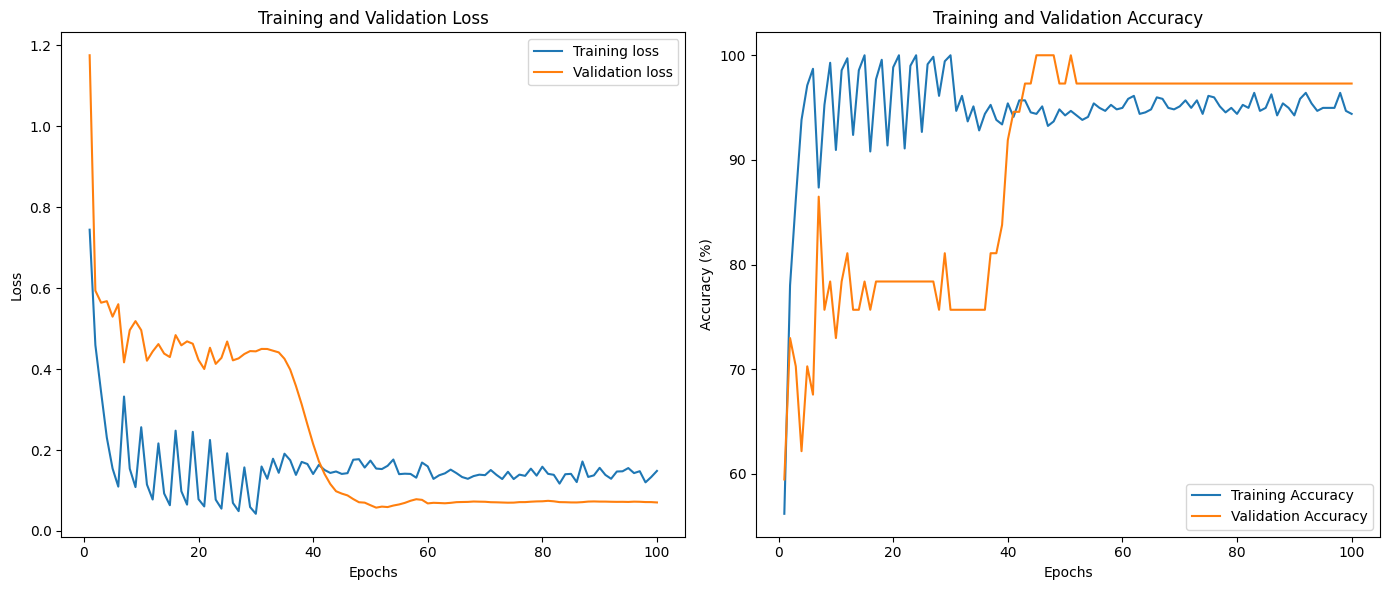

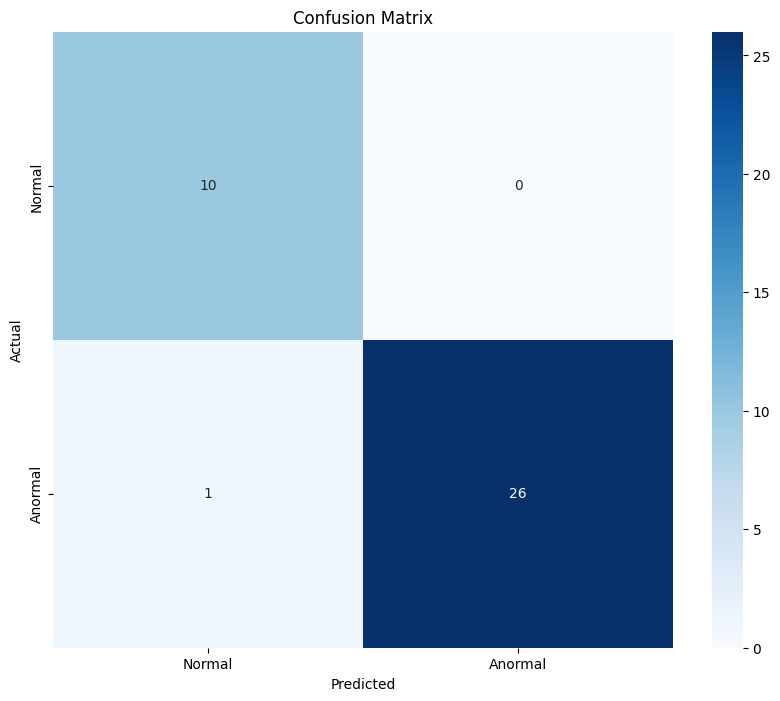

In [ ]:

print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

# Plot training and validation loss and accuracy
epochs = range(1, len(train_loss_list) + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training loss')
plt.plot(epochs, val_loss_list, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal','Anormal'], yticklabels=['Normal','Anormal'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
